In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Quickstart example

In the following example, we use the "test" MRIOT of the pymrio module,
which doesn't require loading additional data and has a low number of sectors and
regions, allowing fast computation.

## Instantiating a model from a MRIOT system

First import the required elements. We use the ARIOPsiModel version here (which you probably should as well).

In [2]:
# import pymrio for the test MRIOT
import pymrio

# import the different classes
from boario.extended_models import ARIOPsiModel  # The core of the model

Some attributes of the test MRIOT are not computed. Calling calc_all() ensures all required tables are present in the IOSystem object. This ``pymrio.IOSystem`` method automatically identifies which tables are missing and calculates them following the IO formal framework. (See [here](https://pymrio.readthedocs.io/en/latest/math.html) for more details.)

In [3]:
mriot = pymrio.load_test().calc_all()

If you see multiple: ``FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do \`frame.T.groupby(...)\` without axis instead.``
don't panic, this comes from `pymrio` but it is not an error, just a syntax warning.

In case you find it annoying, you can use the following beforehand:

In [4]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

Instantiating the model is very straightforward:

In [29]:
model = ARIOPsiModel(mriot)

/home/sjuhel/Repos/BoARIO/boario/model_base.py:277: UserWarning: No capital to VA dictionary given, considering 4/1 ratio
  warnings.warn("No capital to VA dictionary given, considering 4/1 ratio")


This sets the model with all the default parameters. We highly recommand you to study the different parameters and their options for actual use. See [Changing the model parameters](../tutorials/model-params.rst).

By default, the model sets the productive capital of each industry to 4 times their Value Added (as Gross Ouptut - Intermediate Demand), you should **not** rely on this.

Similarly, instantiating a simulation is also quite easy:

In [30]:
from boario.simulation import Simulation  # Simulation wraps the model

sim = Simulation(model, n_temporal_units_to_sim=730)

Once the model and simulation have been instantiated, you can now define an event:

In [31]:
from boario import event

# Instantiate an event.
ev = event.from_scalar_regions_sectors(
    impact=5000000,
    event_monetary_factor=10**6,
    duration=15,
    event_type="rebuild",
    affected_regions=["reg1"],
    affected_sectors=["manufactoring", "mining"],
    impact_sectoral_distrib=model.mriot.x.loc["reg1", "indout"],
    impact_regional_distrib="equal",
    rebuilding_sectors={"construction": 0.55, "manufactoring": 0.45},
    rebuild_tau=180,
)

Here we define an event happening in region ``reg1`` impacting the productive capital of the ``manufactoring``[^note-1] and ``mining`` sectors. The impact is distributed among the two sectors proportional to their production output (`mriot.x`).

Here the entire impact is translated into a reconstruction demand, handled by the ``construction`` (55%) and ``manufactoring`` (45%) sectors. This reconstruction has a characteristic time of 90 unit steps.

There are different types of Event subclasses implented in BoARIO, each with there specificities, to allow the modeling of different types of shocks. See [Defining events](../tutorials/boario-events.rst), for more in depth explanation on how to define events.

[^note-1]: This typo in the "manufacturing" sector's name comes from pymrio.

The event can then be added to the simulation:

In [32]:
# Add the event to the simulation
sim.add_event(ev)

Note that by default, the impact is considered to be in single units of the currency, while often the MRIOTs are in Millions or Thousands. A warning is raised and the values are automatically adjusted accordingly. See [Handling different monetary factors](../tutorials/monetary-factors.rst) for more details.

And the loop can be run:

In [33]:
# Launch the simulation
sim.loop()

Once the simulation ran, you can access and plot the timeseries of the variables (see [Monitoring the variables](../tutorials/simulation-context.rst#monitoring-the-model-variables) for a list of accessible variables).

Here is an example showing the relative change in production in the different sectors in ``"reg1"``.

<Axes: xlabel='step'>

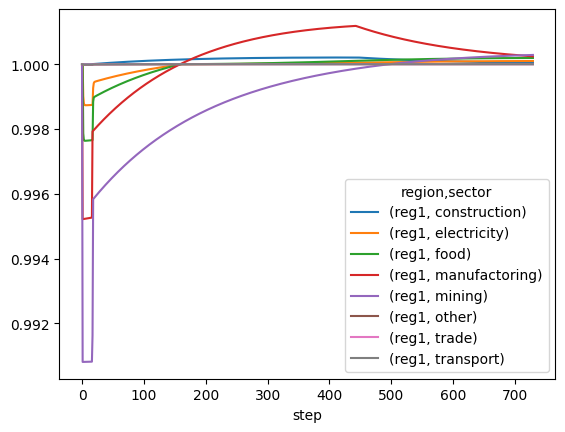

In [34]:
# You can generate a dataframe of
# the production with the following line
df = sim.production_realised
# This allows to normalize production at its initial level
df = df / df.loc[0]

df.loc[:, ("reg1", slice(None))].plot()